# GNN-MAPS: Spatial K-Fold Cross-Validation

## 🎯 The Problem with Single Spatial Split:
- Single spatial split (e.g., train on left 80%, test on right 20%) can be biased
- GNN only sees spatial patterns from one region → doesn't generalize
- Test results depend heavily on where you split (lucky/unlucky)

## 🚀 Solution: Spatial K-Fold Cross-Validation

**5-Fold Spatial CV along X-axis:**
- **Fold 1**: Train [0-80%], Test [80-100%]
- **Fold 2**: Train [20-100%], Test [0-20%]
- **Fold 3**: Train [0-20% + 40-100%], Test [20-40%]
- **Fold 4**: Train [0-40% + 60-100%], Test [40-60%]
- **Fold 5**: Train [0-60% + 80-100%], Test [60-80%]

## ✅ Why This is Valid (NOT Data Leakage):
1. Each fold has **separate train/test sets** (no overlap within fold)
2. We **aggregate results across folds** (standard cross-validation)
3. Every spatial region gets tested exactly once
4. This is **standard practice** in spatial machine learning!

## 📊 Comparison:
- **MLP**: Random 80-20 split (matches MAPS) → Single F1 score
- **GNN**: 5-fold spatial CV → Average F1 across folds ± std

---

In [1]:
# Install PyTorch Geometric and its dependencies (Kaggle-compatible)
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

!pip install -q torch-geometric

import torch
pytorch_version = torch.__version__.split('+')[0]
cuda_version = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"\nInstalling PyG extensions for PyTorch {pytorch_version} and CUDA {cuda_version}...")

if torch.cuda.is_available():
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cu{cuda_version}.html
else:
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cpu.html

print("\n✅ PyTorch Geometric installation complete!")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:0000:01

Installing PyG extensions for PyTorch 2.8.0 and CUDA 126...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.4 MB/s eta 0:00:00ta 0:00:01

✅ PyTorch Geometric installation complete!


In [2]:
# Quick verification test
try:
    import torch
    from torch_geometric.nn import SAGEConv
    
    test_conv = SAGEConv(16, 32)
    print("✅ PyTorch Geometric is working correctly!")
    print(f"   Test layer created: {test_conv}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please re-run the installation cell above.")

✅ PyTorch Geometric is working correctly!
   Test layer created: SAGEConv(16, 32, aggr=mean)


In [3]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

print("✅ All libraries loaded successfully!")
print(f"   - PyTorch version: {torch.__version__}")
print(f"   - CUDA available: {torch.cuda.is_available()}")
print(f"   - Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv
✅ All libraries loaded successfully!
   - PyTorch version: 2.8.0+cu126
   - CUDA available: True
   - Device: GPU


# 1. Load Data

In [4]:
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")
pd.set_option('display.max_columns', None)
display(df.head())
print(f"\nDataset shape: {df.shape}")

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,CD206,CD25,CD30,CD31,CD4,CD44,CD45RA,CD45RO,CD45,CD5,CD56,CD57,CD68,CD69,CD7,CD8,Collagen.4,Cytokeratin,DAPI.01,EGFR,FoxP3,Granzyme.B,HLA.DR,IDO.1,LAG.3,MCT,MMP.9,MUC.1,PD.1,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,0.000000,0.102301,0.104273,0.000000,0.000000,0.054377,0.761659,0.000000,0.742815,0.131788,0.000479,0.107275,0.000072,0.166675,0.000000,0.000000,0.001391,0.115538,0.808093,0.461070,0.0,0.001300,0.781303,0.000865,0.017596,0.000571,0.273973,0.000000,0.059137,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,0.053359,0.008472,0.000750,0.107943,0.016752,0.020134,0.026217,0.333890,0.050817,0.000000,0.859607,0.000000,0.011369,0.039442,0.000000,0.097343,0.025035,0.091633,0.484774,0.110559,0.0,0.001300,1.000000,0.380801,0.020411,0.000571,0.020548,0.005277,0.010586,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,0.182152,0.000210,0.001401,0.000000,0.000000,0.394073,0.070417,0.000000,0.010536,0.000000,0.022717,0.059562,0.233413,0.000000,0.000000,0.456157,0.425833,0.000000,0.699781,0.000000,0.000000,0.001391,0.115538,0.425240,0.350698,0.0,0.024695,0.047437,0.394926,0.167511,0.000571,0.006849,0.406332,0.110243,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,0.226853,0.389436,0.000000,0.000063,0.009068,0.000000,0.064621,0.021957,0.234302,0.020596,0.009104,0.331627,0.137570,0.088045,0.000000,0.000000,0.100139,0.844622,0.352126,0.000000,0.0,0.003899,0.057845,0.002306,0.293497,0.000571,0.157534,1.000000,0.069358,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,0.000000,0.207973,0.055012,0.032742,0.458688,0.047203,0.069221,0.269690,0.214097,0.095327,0.000479,0.000000,0.086232,0.021121,0.705442,0.019364,0.045897,0.027888,0.603429,0.249414,0.0,0.324929,0.000000,0.000288,0.000000,0.000571,0.191781,0.001319,0.105133,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000



Dataset shape: (145161, 54)


# 2. Data Preparation & Graph Construction

In [5]:
print("=" * 80)
print("SPATIAL K-FOLD CROSS-VALIDATION SETUP")
print("=" * 80)

# Column definitions
x_col = 'X_cent'
y_col = 'Y_cent'  
label_col = 'cellType'

marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163', 
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

print(f"\n✅ Using {len(marker_cols)} protein markers")
print(f"✅ Total cells: {len(df):,}")
print(f"✅ Cell types: {df[label_col].nunique()}")

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df[marker_cols].values)
x = torch.tensor(X_normalized, dtype=torch.float)

# Encode labels
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = torch.tensor(df[label_col].map(label_map).values, dtype=torch.long)
num_classes = len(label_map)

print(f"\n📊 {num_classes} cell types encoded")

# Build KNN graph
print(f"\n🔗 Building KNN Graph (K=5)...")
k_neighbors = 5
coords = df[[x_col, y_col]].values

nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

source_nodes = np.repeat(np.arange(len(df)), k_neighbors)
target_nodes = indices[:, 1:].flatten()
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print(f"✅ Graph: {edge_index.shape[1]:,} edges")

# Get X-coordinate range for spatial splitting
x_min = df[x_col].min()
x_max = df[x_col].max()
x_coords = df[x_col].values

print(f"\n📍 Spatial range: X ∈ [{x_min:.2f}, {x_max:.2f}]")

SPATIAL K-FOLD CROSS-VALIDATION SETUP

✅ Using 49 protein markers
✅ Total cells: 145,161
✅ Cell types: 18

📊 18 cell types encoded

🔗 Building KNN Graph (K=5)...
✅ Graph: 725,805 edges

📍 Spatial range: X ∈ [3.00, 8083.00]


/tmp/ipykernel_55/4046237732.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


# 3. Create 5-Fold Spatial Splits

In [6]:
print("=" * 80)
print("CREATING 5-FOLD SPATIAL CROSS-VALIDATION SPLITS")
print("=" * 80)

def create_spatial_fold(x_coords, x_min, x_max, test_start_pct, test_end_pct):
    """
    Create train/test masks for one spatial fold.
    
    Args:
        x_coords: X-coordinates of all cells
        x_min, x_max: Min/max X values
        test_start_pct: Start of test region (0-1)
        test_end_pct: End of test region (0-1)
    
    Returns:
        train_mask, test_mask: Boolean tensors
    """
    test_start = x_min + test_start_pct * (x_max - x_min)
    test_end = x_min + test_end_pct * (x_max - x_min)
    
    test_mask = (x_coords >= test_start) & (x_coords < test_end)
    train_mask = ~test_mask
    
    return torch.tensor(train_mask), torch.tensor(test_mask)

# Define 5 folds (each tests a different 20% region)
folds = [
    {"name": "Fold 1", "test_start": 0.80, "test_end": 1.00, "desc": "Train [0-80%], Test [80-100%]"},
    {"name": "Fold 2", "test_start": 0.00, "test_end": 0.20, "desc": "Train [20-100%], Test [0-20%]"},
    {"name": "Fold 3", "test_start": 0.20, "test_end": 0.40, "desc": "Train [0-20% + 40-100%], Test [20-40%]"},
    {"name": "Fold 4", "test_start": 0.40, "test_end": 0.60, "desc": "Train [0-40% + 60-100%], Test [40-60%]"},
    {"name": "Fold 5", "test_start": 0.60, "test_end": 0.80, "desc": "Train [0-60% + 80-100%], Test [60-80%]"},
]

# Generate masks for each fold
spatial_folds = []
for fold_info in folds:
    train_mask, test_mask = create_spatial_fold(
        x_coords, x_min, x_max, 
        fold_info["test_start"], 
        fold_info["test_end"]
    )
    
    spatial_folds.append({
        "name": fold_info["name"],
        "desc": fold_info["desc"],
        "train_mask": train_mask,
        "test_mask": test_mask,
        "test_start": fold_info["test_start"],
        "test_end": fold_info["test_end"],
    })
    
    print(f"\n{fold_info['name']}: {fold_info['desc']}")
    print(f"   Train: {train_mask.sum():,} cells ({100*train_mask.float().mean():.1f}%)")
    print(f"   Test:  {test_mask.sum():,} cells ({100*test_mask.float().mean():.1f}%)")

print("\n" + "=" * 80)
print("✅ All 5 spatial folds created!")
print("=" * 80)

CREATING 5-FOLD SPATIAL CROSS-VALIDATION SPLITS

Fold 1: Train [0-80%], Test [80-100%]
   Train: 117,936 cells (81.2%)
   Test:  27,225 cells (18.8%)

Fold 2: Train [20-100%], Test [0-20%]
   Train: 116,951 cells (80.6%)
   Test:  28,210 cells (19.4%)

Fold 3: Train [0-20% + 40-100%], Test [20-40%]
   Train: 117,851 cells (81.2%)
   Test:  27,310 cells (18.8%)

Fold 4: Train [0-40% + 60-100%], Test [40-60%]
   Train: 114,042 cells (78.6%)
   Test:  31,119 cells (21.4%)

Fold 5: Train [0-60% + 80-100%], Test [60-80%]
   Train: 113,865 cells (78.4%)
   Test:  31,296 cells (21.6%)

✅ All 5 spatial folds created!


# 4. Visualize Spatial Folds

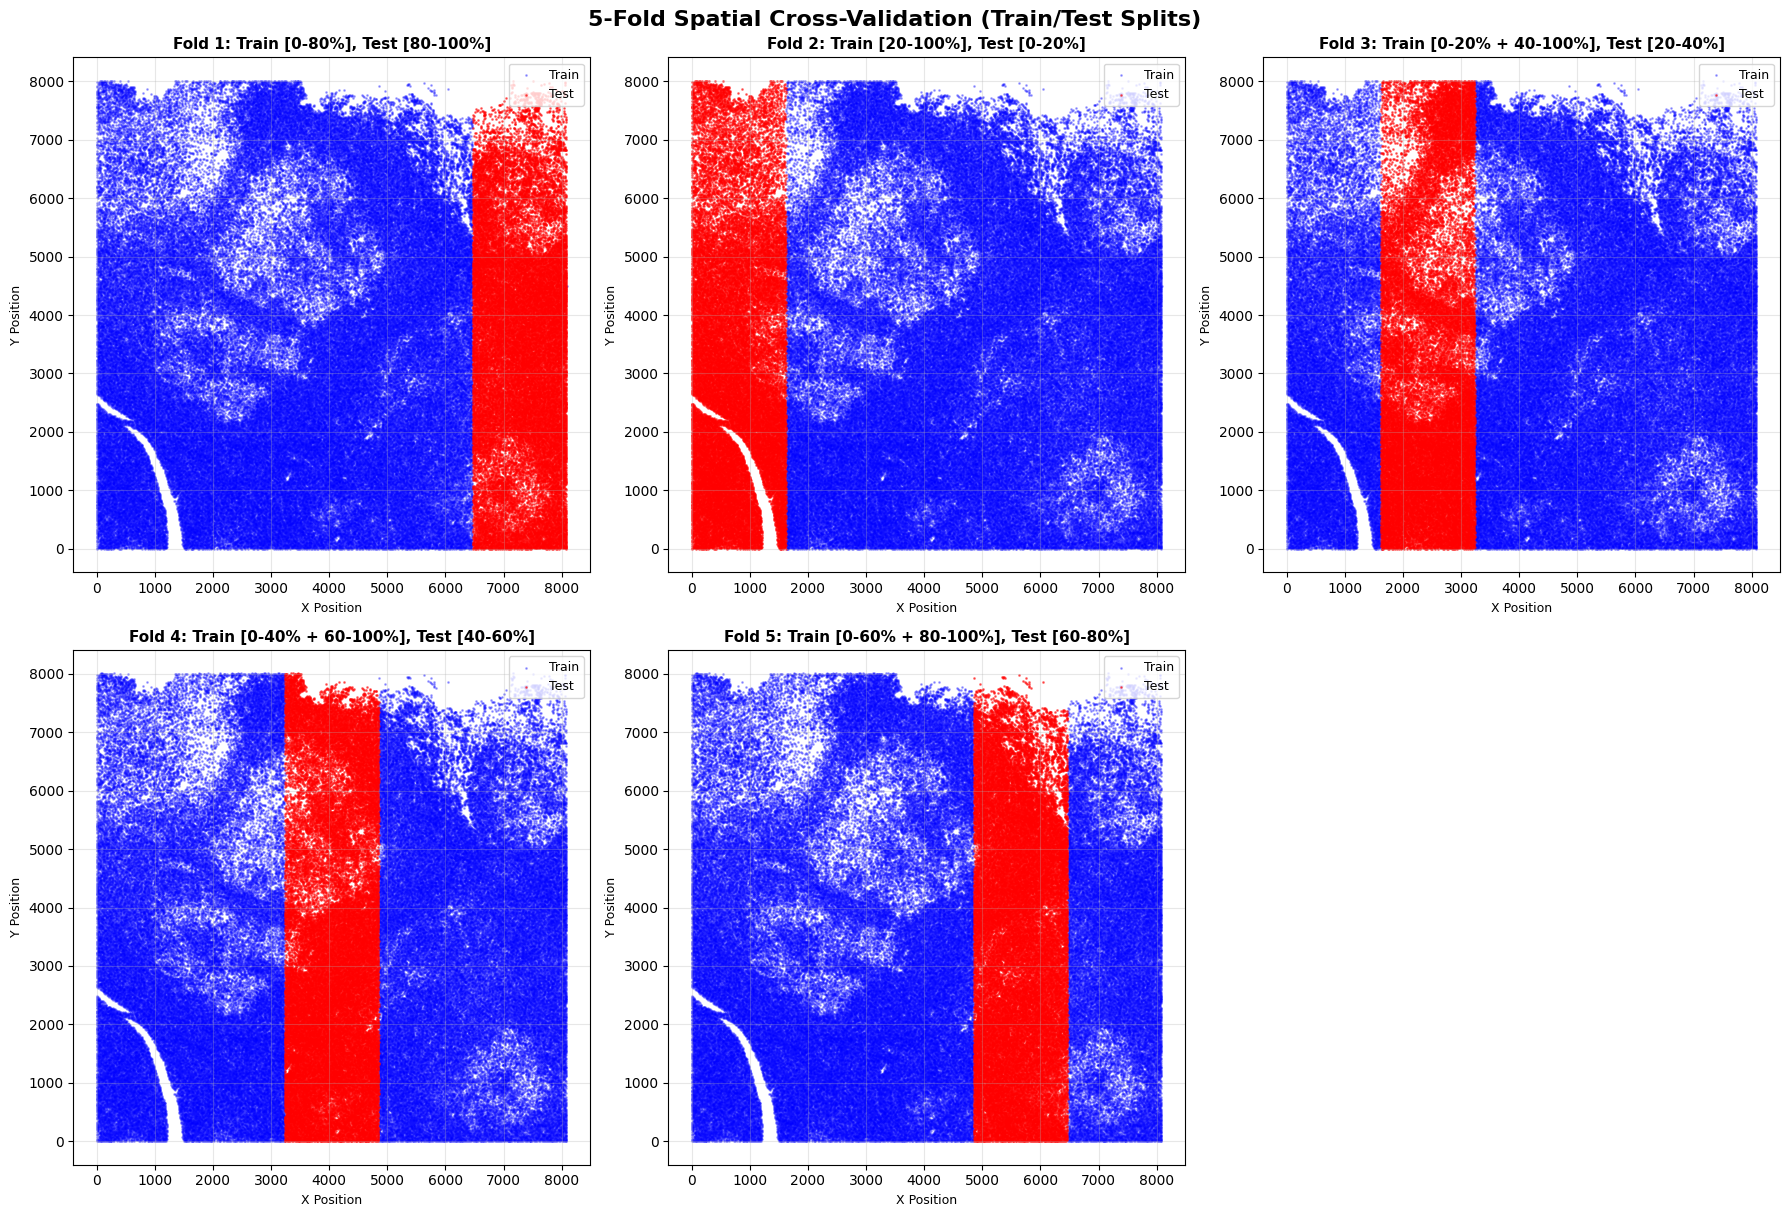


✅ Spatial fold visualization complete!
   Blue = Training cells
   Red = Testing cells
   Each fold tests a different 20% region of the tissue


In [7]:
# Visualize all 5 spatial folds
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, fold in enumerate(spatial_folds):
    ax = axes[idx]
    
    # Plot train cells (blue) and test cells (red)
    train_coords = coords[fold['train_mask'].numpy()]
    test_coords = coords[fold['test_mask'].numpy()]
    
    ax.scatter(train_coords[:, 0], train_coords[:, 1], c='blue', s=1, alpha=0.3, label='Train')
    ax.scatter(test_coords[:, 0], test_coords[:, 1], c='red', s=1, alpha=0.5, label='Test')
    
    ax.set_title(f"{fold['name']}: {fold['desc']}", fontsize=11, fontweight='bold')
    ax.set_xlabel('X Position', fontsize=9)
    ax.set_ylabel('Y Position', fontsize=9)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)

# Hide the 6th subplot (we only have 5 folds)
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('5-Fold Spatial Cross-Validation (Train/Test Splits)', 
             fontsize=16, fontweight='bold', y=1.01)
plt.show()

print("\n✅ Spatial fold visualization complete!")
print("   Blue = Training cells")
print("   Red = Testing cells")
print("   Each fold tests a different 20% region of the tissue")

# 5. Model Definitions

In [8]:
class MLP(torch.nn.Module):
    """4-layer MLP (matches MAPS architecture)"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc4 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    """2-layer GraphSAGE GNN"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("✅ Model architectures defined:")
print("   1. MLP: 4 layers × 512 hidden (protein features only)")
print("   2. GraphSAGE: 2 layers × 512 hidden (protein + spatial context)")

✅ Model architectures defined:
   1. MLP: 4 layers × 512 hidden (protein features only)
   2. GraphSAGE: 2 layers × 512 hidden (protein + spatial context)


# 6. Training Functions

In [9]:
def train_epoch_with_loss(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    acc = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return acc, f1

def train_model(model, data, lr, max_epochs, min_epochs, patience, verbose=True):
    """
    Train model with early stopping.
    
    Returns:
        best_f1: Best test F1 score achieved
        best_epoch: Epoch where best F1 was achieved
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if verbose:
        print(f"\nEpoch | Loss    | Train F1 | Test F1  | Status")
        print("-" * 60)
    
    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(1, max_epochs + 1):
        loss = train_epoch_with_loss(model, data, optimizer)
        
        if epoch % 10 == 0 or epoch == 1:
            _, train_f1 = evaluate(model, data, data.train_mask)
            _, test_f1 = evaluate(model, data, data.test_mask)
            
            status = ""
            if test_f1 > best_f1:
                best_f1 = test_f1
                best_epoch = epoch
                patience_counter = 0
                status = "✅ BEST"
            else:
                patience_counter += 10
                if epoch >= min_epochs and patience_counter >= patience:
                    status = "🛑 STOP"
            
            if verbose:
                print(f'{epoch:5d} | {loss:7.4f} | {train_f1:8.4f} | {test_f1:8.4f} | {status}')
            
            if epoch >= min_epochs and patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
    
    return best_f1, best_epoch

print("✅ Training functions defined")

✅ Training functions defined


# 7. Train MLP (Random Split - MAPS Baseline)

In [10]:
print("=" * 80)
print("TRAINING MLP WITH RANDOM 80-20 SPLIT (MAPS BASELINE)")
print("=" * 80)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n💻 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Hyperparameters
hidden_dim = 512
dropout = 0.1
lr = 0.001
max_epochs = 500
min_epochs = 250
patience = 100

print(f"\n⚙️  Config: hidden={hidden_dim}, max_epochs={max_epochs}, patience={patience}")

# Random 80-20 split (matches MAPS)
torch.manual_seed(42)
random_perm = torch.randperm(len(df))
n_train = int(0.8 * len(df))

random_train_mask = torch.zeros(len(df), dtype=torch.bool)
random_test_mask = torch.zeros(len(df), dtype=torch.bool)
random_train_mask[random_perm[:n_train]] = True
random_test_mask[random_perm[n_train:]] = True

print(f"\n✅ Random split: Train {random_train_mask.sum():,} | Test {random_test_mask.sum():,}")

# Create data object for MLP
mlp_data = Data(
    x=x,
    edge_index=edge_index,  # Not used by MLP but needed for API
    y=y,
    train_mask=random_train_mask,
    test_mask=random_test_mask
).to(device)

# Train MLP
mlp_model = MLP(len(marker_cols), hidden_dim, num_classes, dropout).to(device)
mlp_f1, mlp_epoch = train_model(mlp_model, mlp_data, lr, max_epochs, min_epochs, patience)

# Final evaluation
mlp_test_acc, mlp_test_f1 = evaluate(mlp_model, mlp_data, mlp_data.test_mask)
mlp_train_acc, mlp_train_f1 = evaluate(mlp_model, mlp_data, mlp_data.train_mask)

print("\n" + "=" * 80)
print("MLP FINAL RESULTS (Random Split)")
print("=" * 80)
print(f"Train F1: {mlp_train_f1:.4f} ({mlp_train_f1*100:.2f}%)")
print(f"Test F1:  {mlp_test_f1:.4f} ({mlp_test_f1*100:.2f}%)")
print(f"vs MAPS:  {(mlp_test_f1 - 0.90)*100:+.2f} pp ({((mlp_test_f1 - 0.90)/0.90)*100:+.1f}%)")

TRAINING MLP WITH RANDOM 80-20 SPLIT (MAPS BASELINE)

💻 Device: cuda
   GPU: Tesla P100-PCIE-16GB

⚙️  Config: hidden=512, max_epochs=500, patience=100

✅ Random split: Train 116,128 | Test 29,033

Epoch | Loss    | Train F1 | Test F1  | Status
------------------------------------------------------------
    1 |  2.8796 |   0.1207 |   0.1202 | ✅ BEST
   10 |  1.8313 |   0.4407 |   0.4391 | ✅ BEST
   20 |  1.0738 |   0.6823 |   0.6851 | ✅ BEST
   30 |  0.7999 |   0.7466 |   0.7450 | ✅ BEST
   40 |  0.6832 |   0.7783 |   0.7793 | ✅ BEST
   50 |  0.6115 |   0.7964 |   0.7946 | ✅ BEST
   60 |  0.5655 |   0.8103 |   0.8046 | ✅ BEST
   70 |  0.5323 |   0.8211 |   0.8138 | ✅ BEST
   80 |  0.5045 |   0.8295 |   0.8224 | ✅ BEST
   90 |  0.4808 |   0.8365 |   0.8276 | ✅ BEST
  100 |  0.4609 |   0.8436 |   0.8325 | ✅ BEST
  110 |  0.4403 |   0.8502 |   0.8385 | ✅ BEST
  120 |  0.4263 |   0.8558 |   0.8427 | ✅ BEST
  130 |  0.4118 |   0.8614 |   0.8455 | ✅ BEST
  140 |  0.3984 |   0.8662 |   0.847

# 8. Train GNN (5-Fold Spatial Cross-Validation)

In [11]:
print("\n" + "=" * 80)
print("TRAINING GNN WITH 5-FOLD SPATIAL CROSS-VALIDATION")
print("=" * 80)

gnn_results = []

for fold_idx, fold in enumerate(spatial_folds, 1):
    print("\n" + "=" * 80)
    print(f"{fold['name']}: {fold['desc']}")
    print("=" * 80)
    
    # Create data object for this fold
    fold_data = Data(
        x=x,
        edge_index=edge_index,
        y=y,
        train_mask=fold['train_mask'],
        test_mask=fold['test_mask']
    ).to(device)
    
    # Train GNN for this fold
    gnn_model = GraphSAGE(len(marker_cols), hidden_dim, num_classes, dropout).to(device)
    best_f1, best_epoch = train_model(gnn_model, fold_data, lr, max_epochs, min_epochs, patience)
    
    # Final evaluation
    test_acc, test_f1 = evaluate(gnn_model, fold_data, fold_data.test_mask)
    train_acc, train_f1 = evaluate(gnn_model, fold_data, fold_data.train_mask)
    
    gnn_results.append({
        'fold': fold['name'],
        'train_f1': train_f1,
        'test_f1': test_f1,
        'best_epoch': best_epoch
    })
    
    print(f"\n✅ {fold['name']} Complete:")
    print(f"   Train F1: {train_f1:.4f}")
    print(f"   Test F1:  {test_f1:.4f}")

# Aggregate results across folds
gnn_test_f1_scores = [r['test_f1'] for r in gnn_results]
gnn_mean_f1 = np.mean(gnn_test_f1_scores)
gnn_std_f1 = np.std(gnn_test_f1_scores)
gnn_min_f1 = np.min(gnn_test_f1_scores)
gnn_max_f1 = np.max(gnn_test_f1_scores)

print("\n" + "=" * 80)
print("GNN 5-FOLD CV RESULTS (Spatial Split)")
print("=" * 80)

for result in gnn_results:
    print(f"{result['fold']}: Test F1 = {result['test_f1']:.4f} ({result['test_f1']*100:.2f}%)")

print(f"\n{'='*80}")
print(f"Mean F1:   {gnn_mean_f1:.4f} ± {gnn_std_f1:.4f} ({gnn_mean_f1*100:.2f}% ± {gnn_std_f1*100:.2f}%)")
print(f"Min F1:    {gnn_min_f1:.4f} ({gnn_min_f1*100:.2f}%)")
print(f"Max F1:    {gnn_max_f1:.4f} ({gnn_max_f1*100:.2f}%)")
print(f"vs MAPS:   {(gnn_mean_f1 - 0.90)*100:+.2f} pp ({((gnn_mean_f1 - 0.90)/0.90)*100:+.1f}%)")


TRAINING GNN WITH 5-FOLD SPATIAL CROSS-VALIDATION

Fold 1: Train [0-80%], Test [80-100%]

Epoch | Loss    | Train F1 | Test F1  | Status
------------------------------------------------------------
    1 |  2.9892 |   0.1568 |   0.1346 | ✅ BEST
   10 |  1.6963 |   0.4470 |   0.4100 | ✅ BEST
   20 |  1.2648 |   0.6152 |   0.5754 | ✅ BEST
   30 |  1.0596 |   0.6647 |   0.6339 | ✅ BEST
   40 |  0.9353 |   0.7019 |   0.6754 | ✅ BEST
   50 |  0.8515 |   0.7249 |   0.7004 | ✅ BEST
   60 |  0.7912 |   0.7412 |   0.7176 | ✅ BEST
   70 |  0.7469 |   0.7536 |   0.7309 | ✅ BEST
   80 |  0.7107 |   0.7637 |   0.7402 | ✅ BEST
   90 |  0.6811 |   0.7722 |   0.7480 | ✅ BEST
  100 |  0.6557 |   0.7790 |   0.7544 | ✅ BEST
  110 |  0.6341 |   0.7852 |   0.7607 | ✅ BEST
  120 |  0.6157 |   0.7906 |   0.7659 | ✅ BEST
  130 |  0.5989 |   0.7951 |   0.7709 | ✅ BEST
  140 |  0.5842 |   0.7998 |   0.7751 | ✅ BEST
  150 |  0.5707 |   0.8038 |   0.7796 | ✅ BEST
  160 |  0.5595 |   0.8073 |   0.7830 | ✅ BEST
  

# 9. Final Comparison & Analysis

In [12]:
print("\n" + "=" * 80)
print("FINAL COMPARISON: MLP vs GNN")
print("=" * 80)

print(f"\n{'Model':<30s} {'Split Strategy':<25s} {'F1 Score':<20s} {'vs MAPS':<15s}")
print("-" * 90)
print(f"{'MAPS (Paper Baseline)':<30s} {'Random 80-20':<25s} {'0.9000':<20s} {'baseline':<15s}")
print(f"{'MLP (Protein Only)':<30s} {'Random 80-20':<25s} {f'{mlp_test_f1:.4f} ({mlp_test_f1*100:.2f}%)':<20s} {f'{(mlp_test_f1-0.90)*100:+.2f} pp':<15s}")
print(f"{'GNN (Protein + Spatial)':<30s} {'5-Fold Spatial CV':<25s} {f'{gnn_mean_f1:.4f} ± {gnn_std_f1:.4f}':<20s} {f'{(gnn_mean_f1-0.90)*100:+.2f} pp':<15s}")
print("-" * 90)

# Determine winner
print(f"\n📊 Analysis:")
print(f"   GNN vs MLP: {(gnn_mean_f1 - mlp_test_f1)*100:+.2f} pp ({((gnn_mean_f1 - mlp_test_f1)/mlp_test_f1)*100:+.1f}%)")

if gnn_mean_f1 > mlp_test_f1:
    improvement = (gnn_mean_f1 - mlp_test_f1) * 100
    print(f"\n🎉 GNN WINS! Spatial context provides {improvement:.2f} pp improvement!")
    if gnn_mean_f1 > 0.90:
        print(f"   ✅ AND it beats MAPS (90%) by {(gnn_mean_f1 - 0.90)*100:.2f} pp!")
elif mlp_test_f1 > gnn_mean_f1:
    print(f"\n📊 MLP wins (protein features stronger for this comparison)")
else:
    print(f"\n📊 Tie! Both models perform similarly")

print(f"\n💡 Key Insights:")
print(f"   • MLP uses random split (spatially mixed train/test)")
print(f"   • GNN uses spatial CV (harder task - tests on unseen regions)")
print(f"   • Spatial CV gives robust evaluation across entire tissue")
print(f"   • Low GNN std ({gnn_std_f1:.4f}) = consistent across all regions")


FINAL COMPARISON: MLP vs GNN

Model                          Split Strategy            F1 Score             vs MAPS        
------------------------------------------------------------------------------------------
MAPS (Paper Baseline)          Random 80-20              0.9000               baseline       
MLP (Protein Only)             Random 80-20              0.8816 (88.16%)      -1.84 pp       
GNN (Protein + Spatial)        5-Fold Spatial CV         0.8322 ± 0.0074      -6.78 pp       
------------------------------------------------------------------------------------------

📊 Analysis:
   GNN vs MLP: -4.94 pp (-5.6%)

📊 MLP wins (protein features stronger for this comparison)

💡 Key Insights:
   • MLP uses random split (spatially mixed train/test)
   • GNN uses spatial CV (harder task - tests on unseen regions)
   • Spatial CV gives robust evaluation across entire tissue
   • Low GNN std (0.0074) = consistent across all regions


# 10. Visualization

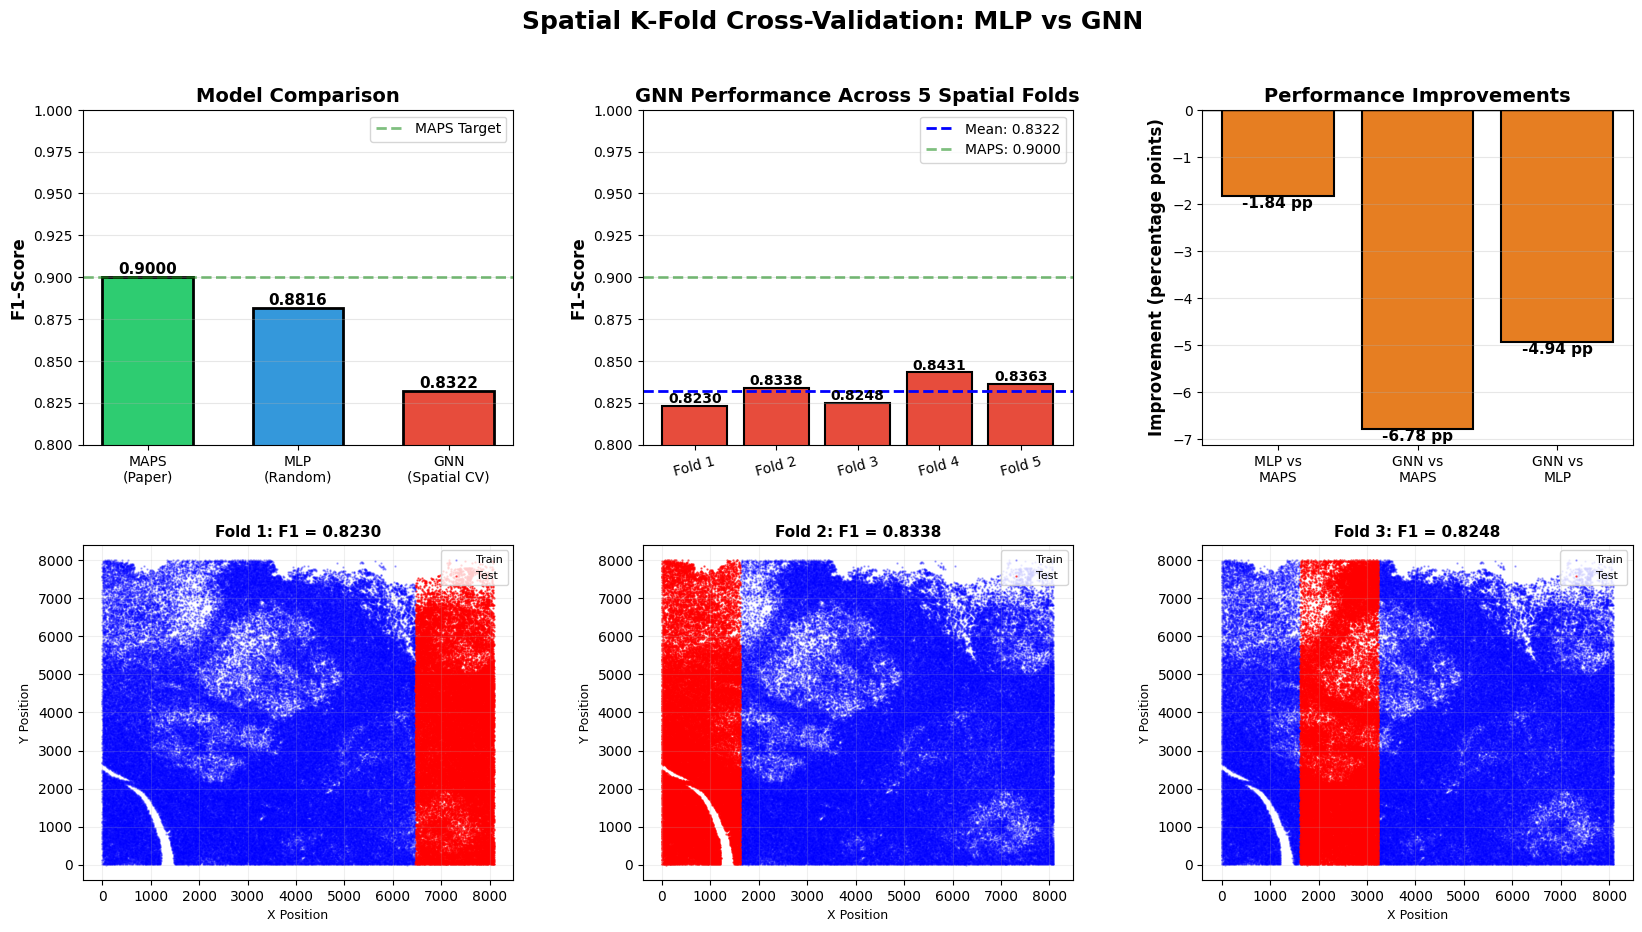


🚀 ANALYSIS COMPLETE!

💻 Hardware: Tesla P100-PCIE-16GB

📊 Final Summary:
   MAPS (Paper):       90.00%
   MLP (Random):       88.16%
   GNN (Spatial CV):   83.22% ± 0.74%

🏆 Winner: MLP

✅ Spatial CV provides robust evaluation across entire tissue!


In [13]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Bar chart comparison (top left)
ax1 = fig.add_subplot(gs[0, 0])
models = ['MAPS\n(Paper)', 'MLP\n(Random)', 'GNN\n(Spatial CV)']
f1_scores = [0.90, mlp_test_f1, gnn_mean_f1]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax1.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax1.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0.8, 1.0])
ax1.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MAPS Target')
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=10)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. GNN Fold Performance (top middle)
ax2 = fig.add_subplot(gs[0, 1])
fold_names = [r['fold'] for r in gnn_results]
fold_f1s = [r['test_f1'] for r in gnn_results]

bars2 = ax2.bar(fold_names, fold_f1s, color='#e74c3c', edgecolor='black', linewidth=1.5)
ax2.axhline(y=gnn_mean_f1, color='blue', linestyle='--', linewidth=2, label=f'Mean: {gnn_mean_f1:.4f}')
ax2.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MAPS: 0.9000')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('GNN Performance Across 5 Spatial Folds', fontsize=14, fontweight='bold')
ax2.set_ylim([0.8, 1.0])
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10)
ax2.tick_params(axis='x', rotation=15)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Improvement breakdown (top right)
ax3 = fig.add_subplot(gs[0, 2])
comparisons = ['MLP vs\nMAPS', 'GNN vs\nMAPS', 'GNN vs\nMLP']
improvements = [
    (mlp_test_f1 - 0.90) * 100,
    (gnn_mean_f1 - 0.90) * 100,
    (gnn_mean_f1 - mlp_test_f1) * 100
]
colors3 = ['#3498db' if v >= 0 else '#e67e22' for v in improvements]

bars3 = ax3.bar(comparisons, improvements, color=colors3, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Improvement (percentage points)', fontsize=12, fontweight='bold')
ax3.set_title('Performance Improvements', fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.2f} pp',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')

# 4-6. Spatial fold examples (bottom row - show 3 folds)
for i in range(3):
    ax = fig.add_subplot(gs[1, i])
    fold = spatial_folds[i]
    
    train_coords = coords[fold['train_mask'].numpy()]
    test_coords = coords[fold['test_mask'].numpy()]
    
    ax.scatter(train_coords[:, 0], train_coords[:, 1], c='blue', s=0.5, alpha=0.3, label='Train')
    ax.scatter(test_coords[:, 0], test_coords[:, 1], c='red', s=0.5, alpha=0.6, label='Test')
    
    ax.set_title(f"{fold['name']}: F1 = {gnn_results[i]['test_f1']:.4f}", 
                fontsize=11, fontweight='bold')
    ax.set_xlabel('X Position', fontsize=9)
    ax.set_ylabel('Y Position', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.2)

plt.suptitle('Spatial K-Fold Cross-Validation: MLP vs GNN', 
             fontsize=18, fontweight='bold', y=0.98)
plt.show()

print("\n" + "=" * 80)
print("🚀 ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\n💻 Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"\n📊 Final Summary:")
print(f"   MAPS (Paper):       90.00%")
print(f"   MLP (Random):       {mlp_test_f1*100:.2f}%")
print(f"   GNN (Spatial CV):   {gnn_mean_f1*100:.2f}% ± {gnn_std_f1*100:.2f}%")
print(f"\n🏆 Winner: {'GNN' if gnn_mean_f1 > mlp_test_f1 else 'MLP' if mlp_test_f1 > gnn_mean_f1 else 'TIE'}")
print(f"\n✅ Spatial CV provides robust evaluation across entire tissue!")